In [2]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import gc
import collections
import statsmodels.api as sm
import scipy
import xarray as xr

# Third-party dependencies
# NOTE: Local xeofs to be submitted as pull-request (addition of xeofs.model.reconstruct_randomized_X method)
from xeofs.xarray import EOF
from xarrayutils.utils import linear_trend

In [3]:
# Define local plotting parameters
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 25})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue')

In [90]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
cise_file_path = 'cise_data/'
reconstructions_neofs_path = 'reconstructions_neofs/'
std_file_path = 'standardized_rec_data/'

In [5]:
data = xr.open_dataset(inDirName + regriddedFluxSSH_filepath)
flux = data.timeMonthly_avg_landIceFreshwaterFlux
ssh = data.timeMonthly_avg_ssh

# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();
# Specify projection for data file
data.rio.write_crs("epsg:3031",inplace=True);
# Specify projection for data file flux array
flux.rio.write_crs("epsg:3031",inplace=True);

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [12]:
flux_ts = flux.sum(['x','y'])

In [13]:
flux_ts_demeaned = flux_ts - flux_ts.mean('time')

In [5]:
iceshelves_dedrafted_total = xr.open_dataset(inDirName+
                                             interim_data_folder+
                                             flux_dedrafted_iceshelves_data_path+
                                             'iceshelves_dedrafted_total.nc')

In [6]:
flux_dedraft = iceshelves_dedrafted_total.timeMonthly_avg_landIceFreshwaterFlux
h = ssh

In [19]:
flux_dedraft_ts = flux_dedraft.sum(['x','y'])

Text(0.5, 0, 'Time (months)')

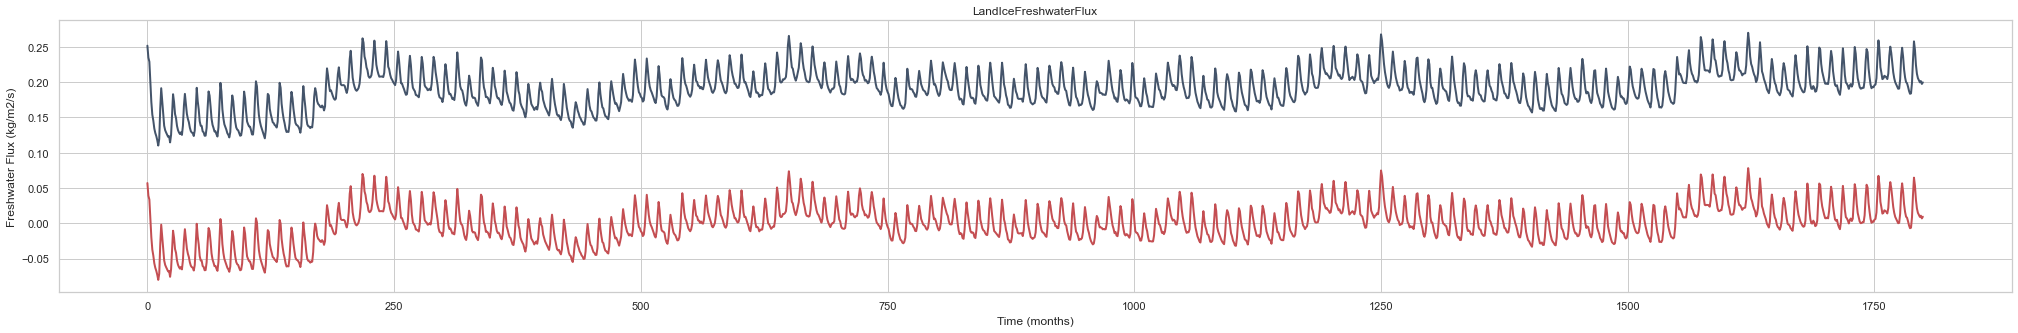

In [20]:
plt.figure(figsize=(35,5))
plt.plot(flux_ts, color = '#44546A', linewidth=2)
plt.plot(flux_dedraft_ts, color = 'r', linewidth=2)
plt.title('LandIceFreshwaterFlux')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

Text(0.5, 0, 'Time (months)')

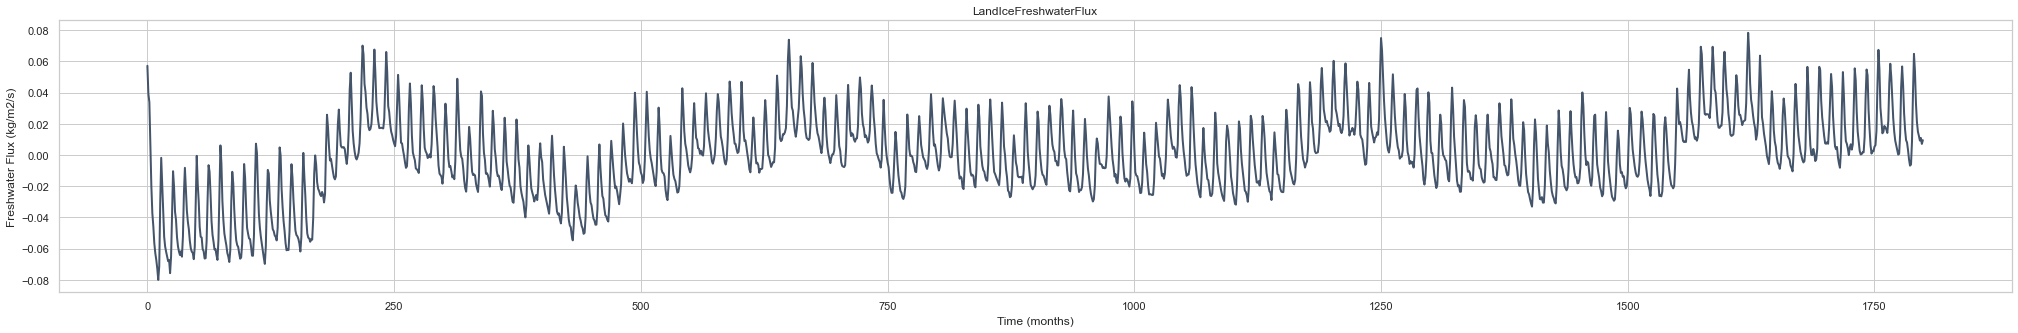

In [21]:
plt.figure(figsize=(35,5))
plt.plot(flux_dedraft_ts, color = '#44546A', linewidth=2)
plt.title('LandIceFreshwaterFlux')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

In [8]:
# Demean: remove temporal mean
flux_dedraft_tmean = flux_dedraft.mean('time')
flux_dedraft_demeaned = flux_dedraft - flux_dedraft_tmean

In [23]:
flux_dedraft_demeaned_ts = flux_dedraft_demeaned.sum(['x','y'])

Text(0.5, 0, 'Time (months)')

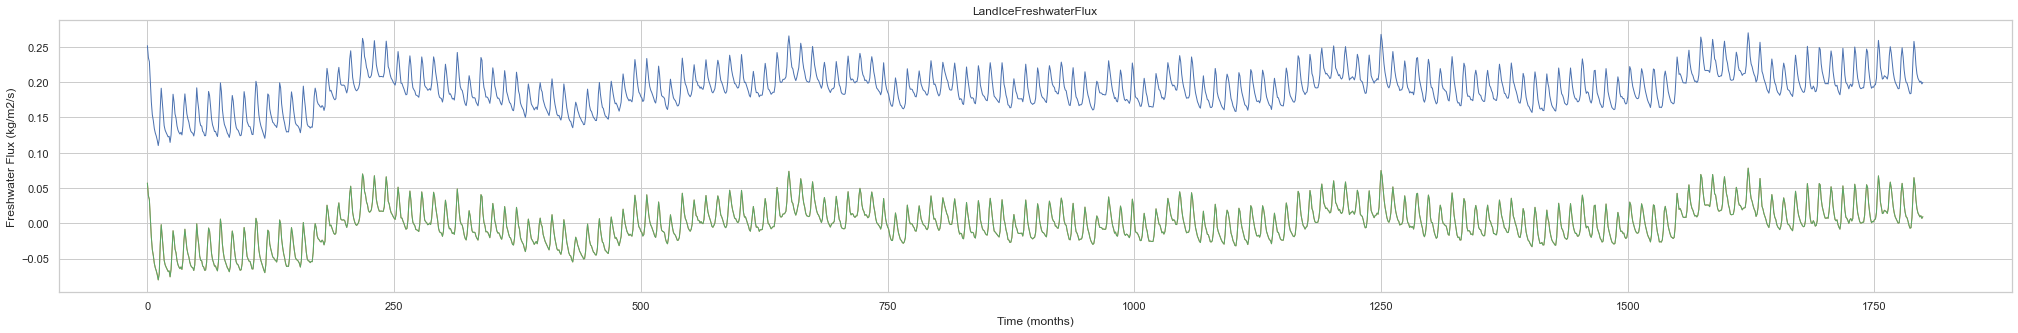

In [24]:
plt.figure(figsize=(35,5))
plt.plot(flux_ts, linewidth=1)
plt.plot(flux_dedraft_ts, linewidth=1)
plt.plot(flux_dedraft_demeaned_ts, linewidth=1)
plt.title('LandIceFreshwaterFlux')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

In [9]:
# Deseasonalize
# Remove climatologies to isolate anomalies / deseasonalize 
flux_month = flux_dedraft_demeaned.groupby("time.month")
flux_clm = flux_month.mean("time") # Climatologies
flux_anm = flux_month - flux_clm # Deseasonalized anomalies

In [26]:
flux_clm_ts = flux_clm.sum(['x','y'])
flux_anm_ts = flux_anm.sum(['x','y'])

In [27]:
flux_month_ts = flux_month.sum(['x','y'])

Text(0.5, 0, 'Time (months)')

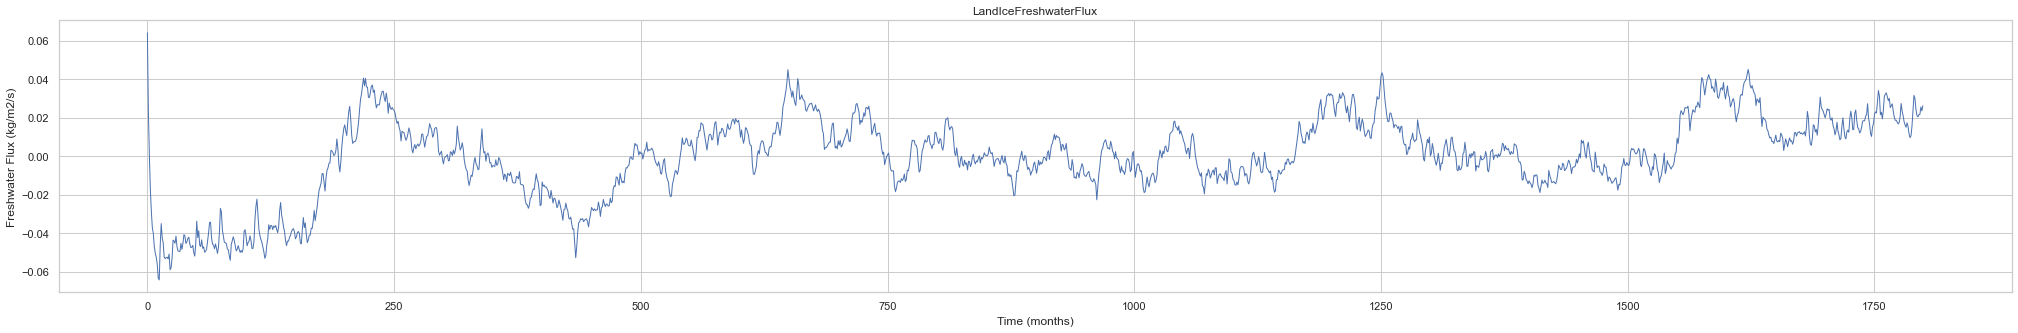

In [29]:
plt.figure(figsize=(35,5))
#plt.plot(flux_ts, linewidth=1)
#plt.plot(flux_dedraft_ts, linewidth=1)
#plt.plot(flux_dedraft_demeaned_ts, linewidth=1)
#plt.plot(flux_month_ts, linewidth=1)
plt.plot(flux_anm_ts, linewidth=1)
plt.title('LandIceFreshwaterFlux')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

In [17]:
# Remove initial 'model spinup period' data before analysis

spinup_period_years = 25 # Verify period of datapoints to be removed before PCA
spinup_time_period = 12*spinup_period_years
flux_clean = flux_anm[spinup_time_period:]

In [6]:
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

In [31]:
flux_clean_ts = flux_clean.sum(['x','y'])

Text(0.5, 0, 'Time (months)')

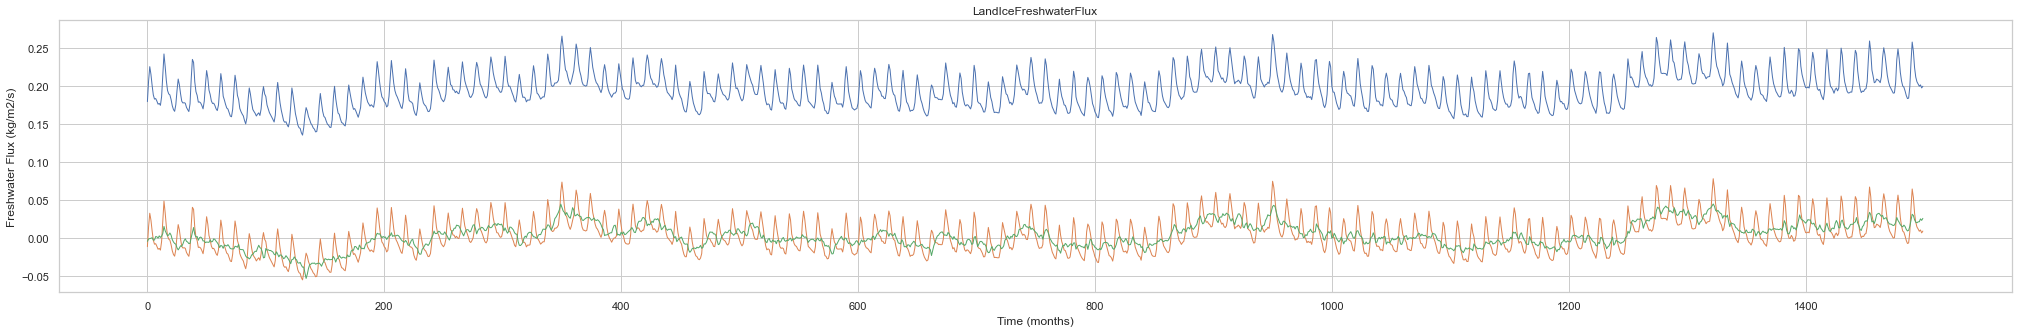

In [32]:
plt.figure(figsize=(35,5))
plt.plot(flux_ts[spinup_time_period:], linewidth=1)
plt.plot(flux_dedraft_ts[spinup_time_period:], linewidth=1)
plt.plot(flux_clean_ts, linewidth=1)
plt.title('LandIceFreshwaterFlux')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

In [33]:
flux_clean_demeaned = flux_clean - flux_clean.mean('time')
flux_clean_demeaned_ts = flux_clean_demeaned.sum(['x','y'])

Text(0.5, 0, 'Time (months)')

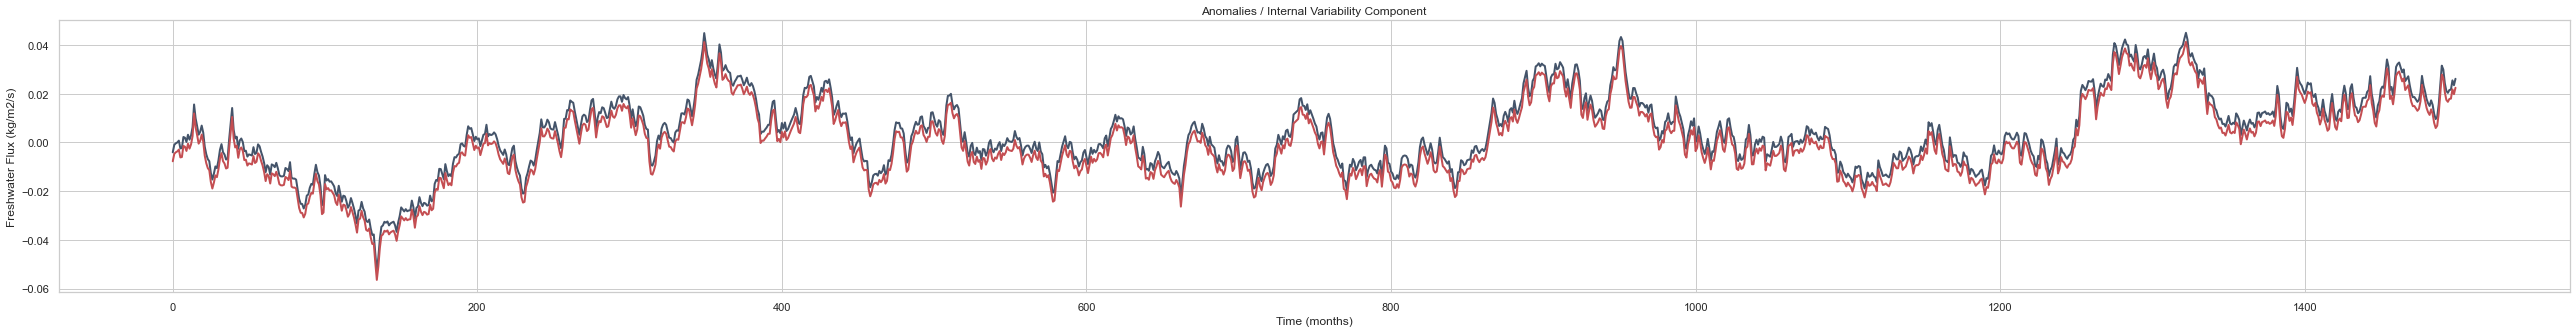

In [34]:
# Figure: Anomalies / Internal Variability Component of Input Data: Temporal Variability
plt.figure(figsize=(45,5))
#plt.plot(flux_anm_ts)
plt.plot(flux_clean_ts[:], color = '#44546A', linewidth=2)
plt.plot(flux_clean_demeaned_ts[:], color = 'r', linewidth=2)
plt.title('Anomalies / Internal Variability Component')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

## Spatial Decomposition: EOF

### Clean

In [22]:
%%time
model = EOF(flux_clean)
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
varexpl = model.explained_variance_ratio()

CPU times: user 2min 25s, sys: 48.6 s, total: 3min 14s
Wall time: 46.5 s


### Clean_Demeaned

In [114]:
%%time
dmmodel = EOF(flux_clean_demeaned)
dmmodel.solve()
dmeofs = dmmodel.eofs()
dmpcs = dmmodel.pcs()
dmnmodes = dmmodel.n_modes
dmvarexpl = dmmodel.explained_variance_ratio()

CPU times: user 2min 1s, sys: 40.3 s, total: 2min 42s
Wall time: 44.4 s


### Clean_Standardized

In [ ]:
flux_clean_tmean = flux_clean.mean('time')
flux_clean_tstd = flux_clean.std('time')

In [76]:
flux_clean_standardized = flux_clean_demeaned/flux_clean.std('time')
flux_clean_standardized_ts = flux_clean_standardized.mean(['x','y'])

Text(0.5, 0, 'Time (months)')

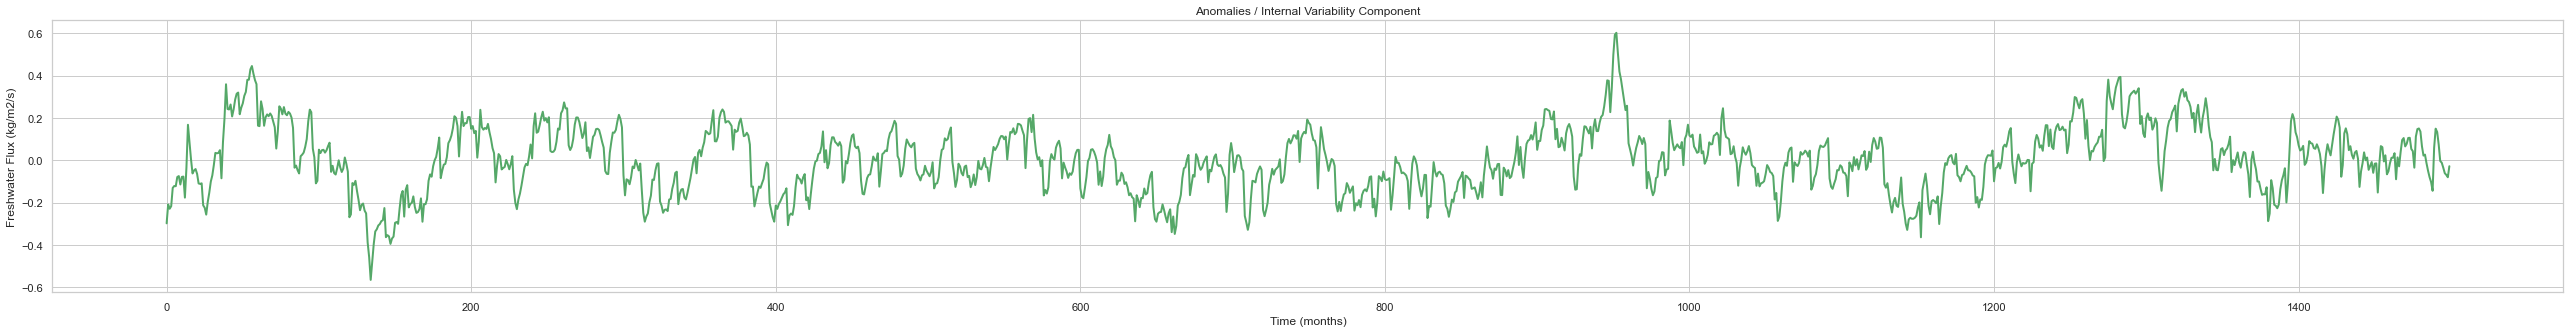

In [82]:
# Figure: Anomalies / Internal Variability Component of Input Data: Temporal Variability
plt.figure(figsize=(45,5))
#plt.plot(flux_anm_ts)
#plt.plot(flux_clean_ts[:], color = '#44546A', linewidth=2)
#plt.plot(flux_clean_demeaned_ts[:], color = 'r', linewidth=2)
plt.plot(flux_clean_standardized_ts[:], color = 'g', linewidth=2)
plt.title('Anomalies / Internal Variability Component')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

In [23]:
%%time
stdmodel = EOF(flux_clean_standardized)
stdmodel.solve()
stdeofs = stdmodel.eofs()
stdpcs = stdmodel.pcs()
stdnmodes = stdmodel.n_modes
stdvarexpl = stdmodel.explained_variance_ratio()

CPU times: user 57.8 s, sys: 23 s, total: 1min 20s
Wall time: 30.1 s


### Sparse Clean

In [12]:
%%time
model = EOF(flux_clean)
model.sparsesolve(0.05)
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
#varexpl = model.explained_variance_ratio()

CPU times: user 4min 39s, sys: 46 s, total: 5min 25s
Wall time: 2min 30s


### Sparse Clean_Standardized

In [16]:
flux_clean_demeaned = flux_clean - flux_clean.mean('time')
flux_clean_standardized = flux_clean_demeaned/flux_clean.std('time')

In [19]:
%%time
model = EOF(flux_clean)
model.sparsesolve(0)
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
#varexpl = model.explained_variance_ratio()

CPU times: user 4min 58s, sys: 53.9 s, total: 5min 52s
Wall time: 2min 34s


## Figures

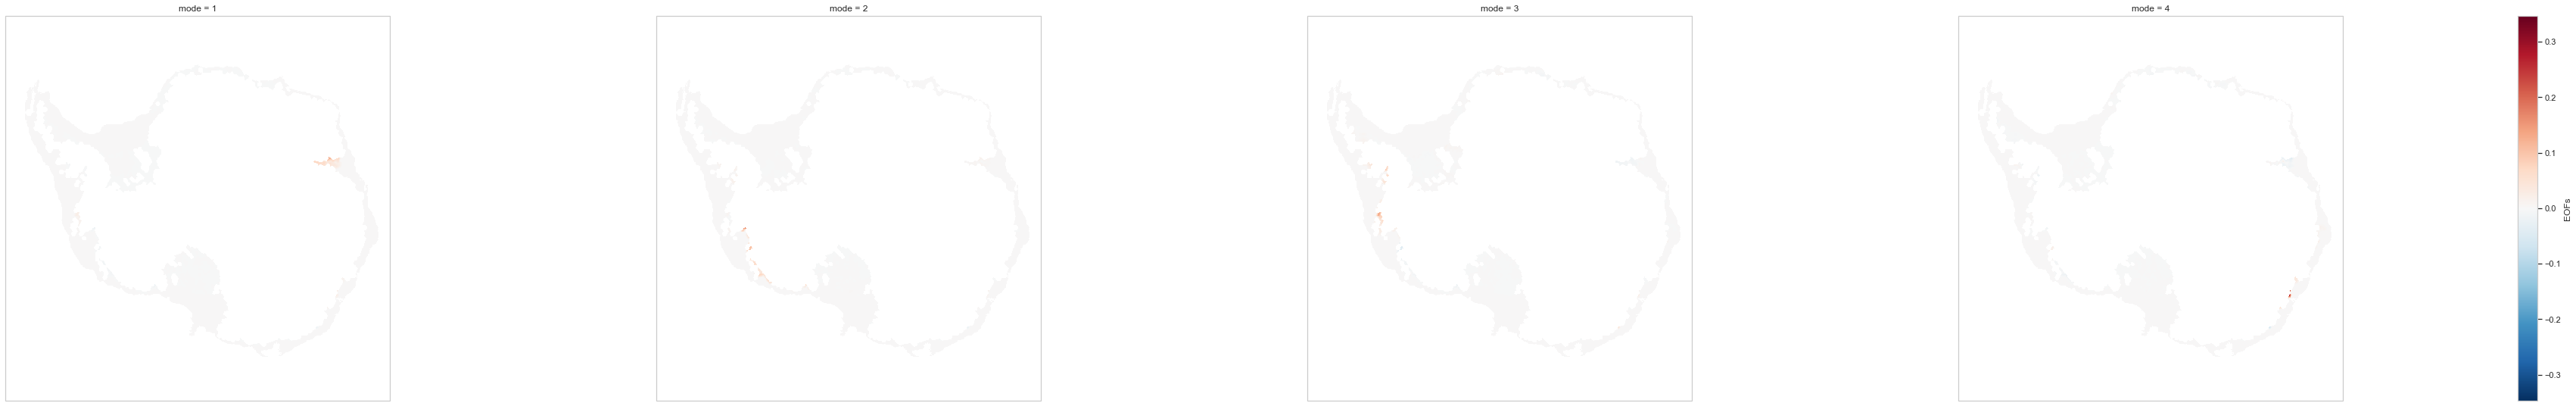

In [70]:
# Figure: Dominant EOF modes
fg = eofs[:,:,0:4].plot(aspect=2,
                        size=8,
                        col="mode", 
                        col_wrap=4,
                        subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

# TODO: Redefine vmax, vmin 

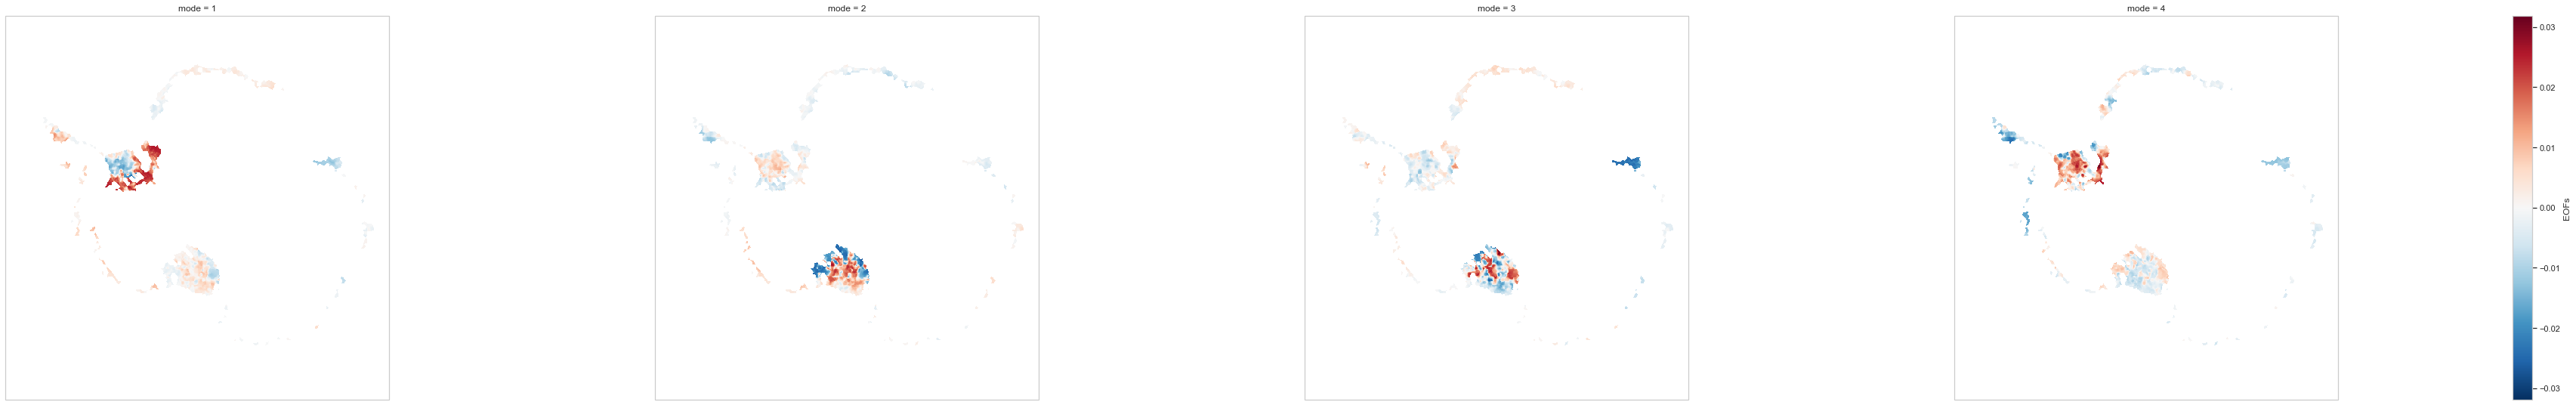

In [71]:
# Figure: Dominant EOF modes
fg = stdeofs[:,:,0:4].plot(aspect=2,
                                size=8,
                                col="mode", 
                                col_wrap=4,
                                subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

# TODO: Redefine vmax, vmin 

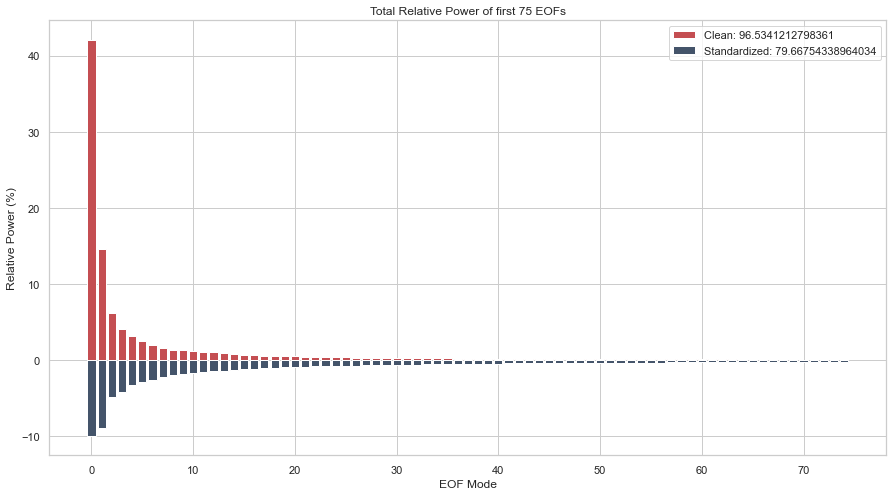

In [72]:
# Figure: Relative power of m EOFs
m = 75

plt.figure(figsize=(15,8))
plt.bar(range(m),varexpl[:m]*100, 
        color='r', 
        label='Clean: {}'.format(varexpl[:m].sum().values*100))
plt.bar(range(m),-stdvarexpl[:m]*100, 
        color='#44546A', 
        label='Standardized: {}'.format(stdvarexpl[:m].sum().values*100))
plt.ylabel('Relative Power (%)')
plt.xlabel('EOF Mode')
plt.title('Total Relative Power of first {} EOFs'.format(m))
plt.legend()

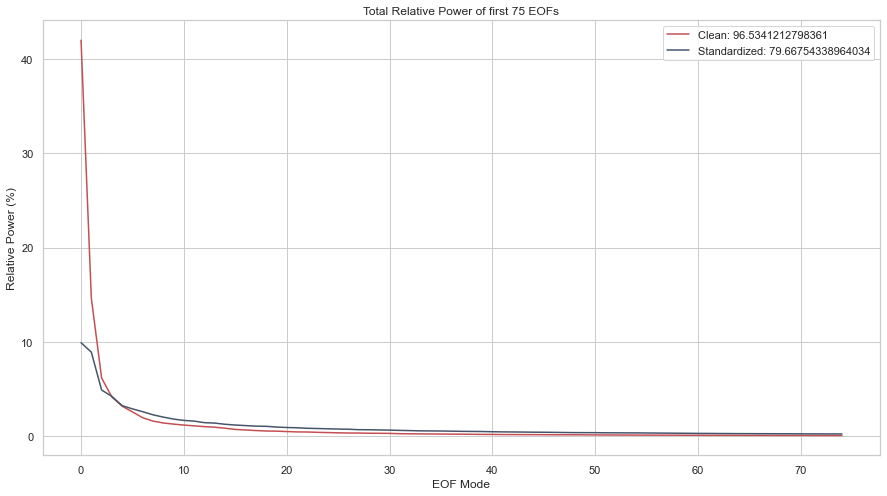

In [67]:
# Figure: Relative power of m EOFs
m = 75

plt.figure(figsize=(15,8))
plt.plot(range(m),varexpl[:m]*100,#'.',
        color='r',
        label='Clean: {}'.format(varexpl[:m].sum().values*100))
plt.plot(range(m),stdvarexpl[:m]*100,#'x',
        color='#44546A',
        label='Standardized: {}'.format(stdvarexpl[:m].sum().values*100))
plt.ylabel('Relative Power (%)')
plt.xlabel('EOF Mode')
plt.title('Total Relative Power of first {} EOFs'.format(m))
plt.legend()

In [73]:
catchments = np.array([1,81,70,71])

## Fourier Phase Randomization

In [77]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 3
t_length = stdpcs.shape[0]

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,stdpcs.shape[0],stdpcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(nmodes):
        fl = stdpcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
        print('calculated ifft for realization {}, mode: {}'.format(i,m))

calculated ifft for realization 0, mode: 0
calculated ifft for realization 0, mode: 1
calculated ifft for realization 0, mode: 2
calculated ifft for realization 0, mode: 3
calculated ifft for realization 0, mode: 4
calculated ifft for realization 0, mode: 5
calculated ifft for realization 0, mode: 6
calculated ifft for realization 0, mode: 7
calculated ifft for realization 0, mode: 8
calculated ifft for realization 0, mode: 9
calculated ifft for realization 0, mode: 10
calculated ifft for realization 0, mode: 11
calculated ifft for realization 0, mode: 12
calculated ifft for realization 0, mode: 13
calculated ifft for realization 0, mode: 14
calculated ifft for realization 0, mode: 15
calculated ifft for realization 0, mode: 16
calculated ifft for realization 0, mode: 17
calculated ifft for realization 0, mode: 18
calculated ifft for realization 0, mode: 19
calculated ifft for realization 0, mode: 20
calculated ifft for realization 0, mode: 21
calculated ifft for realization 0, mode: 2

calculated ifft for realization 0, mode: 501
calculated ifft for realization 0, mode: 502
calculated ifft for realization 0, mode: 503
calculated ifft for realization 0, mode: 504
calculated ifft for realization 0, mode: 505
calculated ifft for realization 0, mode: 506
calculated ifft for realization 0, mode: 507
calculated ifft for realization 0, mode: 508
calculated ifft for realization 0, mode: 509
calculated ifft for realization 0, mode: 510
calculated ifft for realization 0, mode: 511
calculated ifft for realization 0, mode: 512
calculated ifft for realization 0, mode: 513
calculated ifft for realization 0, mode: 514
calculated ifft for realization 0, mode: 515
calculated ifft for realization 0, mode: 516
calculated ifft for realization 0, mode: 517
calculated ifft for realization 0, mode: 518
calculated ifft for realization 0, mode: 519
calculated ifft for realization 0, mode: 520
calculated ifft for realization 0, mode: 521
calculated ifft for realization 0, mode: 522
calculated

calculated ifft for realization 0, mode: 990
calculated ifft for realization 0, mode: 991
calculated ifft for realization 0, mode: 992
calculated ifft for realization 0, mode: 993
calculated ifft for realization 0, mode: 994
calculated ifft for realization 0, mode: 995
calculated ifft for realization 0, mode: 996
calculated ifft for realization 0, mode: 997
calculated ifft for realization 0, mode: 998
calculated ifft for realization 0, mode: 999
calculated ifft for realization 0, mode: 1000
calculated ifft for realization 0, mode: 1001
calculated ifft for realization 0, mode: 1002
calculated ifft for realization 0, mode: 1003
calculated ifft for realization 0, mode: 1004
calculated ifft for realization 0, mode: 1005
calculated ifft for realization 0, mode: 1006
calculated ifft for realization 0, mode: 1007
calculated ifft for realization 0, mode: 1008
calculated ifft for realization 0, mode: 1009
calculated ifft for realization 0, mode: 1010
calculated ifft for realization 0, mode: 101

calculated ifft for realization 0, mode: 1492
calculated ifft for realization 0, mode: 1493
calculated ifft for realization 0, mode: 1494
calculated ifft for realization 0, mode: 1495
calculated ifft for realization 0, mode: 1496
calculated ifft for realization 0, mode: 1497
calculated ifft for realization 0, mode: 1498
calculated ifft for realization 0, mode: 1499
calculated ifft for realization 1, mode: 0
calculated ifft for realization 1, mode: 1
calculated ifft for realization 1, mode: 2
calculated ifft for realization 1, mode: 3
calculated ifft for realization 1, mode: 4
calculated ifft for realization 1, mode: 5
calculated ifft for realization 1, mode: 6
calculated ifft for realization 1, mode: 7
calculated ifft for realization 1, mode: 8
calculated ifft for realization 1, mode: 9
calculated ifft for realization 1, mode: 10
calculated ifft for realization 1, mode: 11
calculated ifft for realization 1, mode: 12
calculated ifft for realization 1, mode: 13
calculated ifft for realiz

calculated ifft for realization 1, mode: 477
calculated ifft for realization 1, mode: 478
calculated ifft for realization 1, mode: 479
calculated ifft for realization 1, mode: 480
calculated ifft for realization 1, mode: 481
calculated ifft for realization 1, mode: 482
calculated ifft for realization 1, mode: 483
calculated ifft for realization 1, mode: 484
calculated ifft for realization 1, mode: 485
calculated ifft for realization 1, mode: 486
calculated ifft for realization 1, mode: 487
calculated ifft for realization 1, mode: 488
calculated ifft for realization 1, mode: 489
calculated ifft for realization 1, mode: 490
calculated ifft for realization 1, mode: 491
calculated ifft for realization 1, mode: 492
calculated ifft for realization 1, mode: 493
calculated ifft for realization 1, mode: 494
calculated ifft for realization 1, mode: 495
calculated ifft for realization 1, mode: 496
calculated ifft for realization 1, mode: 497
calculated ifft for realization 1, mode: 498
calculated

calculated ifft for realization 1, mode: 947
calculated ifft for realization 1, mode: 948
calculated ifft for realization 1, mode: 949
calculated ifft for realization 1, mode: 950
calculated ifft for realization 1, mode: 951
calculated ifft for realization 1, mode: 952
calculated ifft for realization 1, mode: 953
calculated ifft for realization 1, mode: 954
calculated ifft for realization 1, mode: 955
calculated ifft for realization 1, mode: 956
calculated ifft for realization 1, mode: 957
calculated ifft for realization 1, mode: 958
calculated ifft for realization 1, mode: 959
calculated ifft for realization 1, mode: 960
calculated ifft for realization 1, mode: 961
calculated ifft for realization 1, mode: 962
calculated ifft for realization 1, mode: 963
calculated ifft for realization 1, mode: 964
calculated ifft for realization 1, mode: 965
calculated ifft for realization 1, mode: 966
calculated ifft for realization 1, mode: 967
calculated ifft for realization 1, mode: 968
calculated

calculated ifft for realization 1, mode: 1435
calculated ifft for realization 1, mode: 1436
calculated ifft for realization 1, mode: 1437
calculated ifft for realization 1, mode: 1438
calculated ifft for realization 1, mode: 1439
calculated ifft for realization 1, mode: 1440
calculated ifft for realization 1, mode: 1441
calculated ifft for realization 1, mode: 1442
calculated ifft for realization 1, mode: 1443
calculated ifft for realization 1, mode: 1444
calculated ifft for realization 1, mode: 1445
calculated ifft for realization 1, mode: 1446
calculated ifft for realization 1, mode: 1447
calculated ifft for realization 1, mode: 1448
calculated ifft for realization 1, mode: 1449
calculated ifft for realization 1, mode: 1450
calculated ifft for realization 1, mode: 1451
calculated ifft for realization 1, mode: 1452
calculated ifft for realization 1, mode: 1453
calculated ifft for realization 1, mode: 1454
calculated ifft for realization 1, mode: 1455
calculated ifft for realization 1,

calculated ifft for realization 2, mode: 408
calculated ifft for realization 2, mode: 409
calculated ifft for realization 2, mode: 410
calculated ifft for realization 2, mode: 411
calculated ifft for realization 2, mode: 412
calculated ifft for realization 2, mode: 413
calculated ifft for realization 2, mode: 414
calculated ifft for realization 2, mode: 415
calculated ifft for realization 2, mode: 416
calculated ifft for realization 2, mode: 417
calculated ifft for realization 2, mode: 418
calculated ifft for realization 2, mode: 419
calculated ifft for realization 2, mode: 420
calculated ifft for realization 2, mode: 421
calculated ifft for realization 2, mode: 422
calculated ifft for realization 2, mode: 423
calculated ifft for realization 2, mode: 424
calculated ifft for realization 2, mode: 425
calculated ifft for realization 2, mode: 426
calculated ifft for realization 2, mode: 427
calculated ifft for realization 2, mode: 428
calculated ifft for realization 2, mode: 429
calculated

calculated ifft for realization 2, mode: 900
calculated ifft for realization 2, mode: 901
calculated ifft for realization 2, mode: 902
calculated ifft for realization 2, mode: 903
calculated ifft for realization 2, mode: 904
calculated ifft for realization 2, mode: 905
calculated ifft for realization 2, mode: 906
calculated ifft for realization 2, mode: 907
calculated ifft for realization 2, mode: 908
calculated ifft for realization 2, mode: 909
calculated ifft for realization 2, mode: 910
calculated ifft for realization 2, mode: 911
calculated ifft for realization 2, mode: 912
calculated ifft for realization 2, mode: 913
calculated ifft for realization 2, mode: 914
calculated ifft for realization 2, mode: 915
calculated ifft for realization 2, mode: 916
calculated ifft for realization 2, mode: 917
calculated ifft for realization 2, mode: 918
calculated ifft for realization 2, mode: 919
calculated ifft for realization 2, mode: 920
calculated ifft for realization 2, mode: 921
calculated

calculated ifft for realization 2, mode: 1394
calculated ifft for realization 2, mode: 1395
calculated ifft for realization 2, mode: 1396
calculated ifft for realization 2, mode: 1397
calculated ifft for realization 2, mode: 1398
calculated ifft for realization 2, mode: 1399
calculated ifft for realization 2, mode: 1400
calculated ifft for realization 2, mode: 1401
calculated ifft for realization 2, mode: 1402
calculated ifft for realization 2, mode: 1403
calculated ifft for realization 2, mode: 1404
calculated ifft for realization 2, mode: 1405
calculated ifft for realization 2, mode: 1406
calculated ifft for realization 2, mode: 1407
calculated ifft for realization 2, mode: 1408
calculated ifft for realization 2, mode: 1409
calculated ifft for realization 2, mode: 1410
calculated ifft for realization 2, mode: 1411
calculated ifft for realization 2, mode: 1412
calculated ifft for realization 2, mode: 1413
calculated ifft for realization 2, mode: 1414
calculated ifft for realization 2,

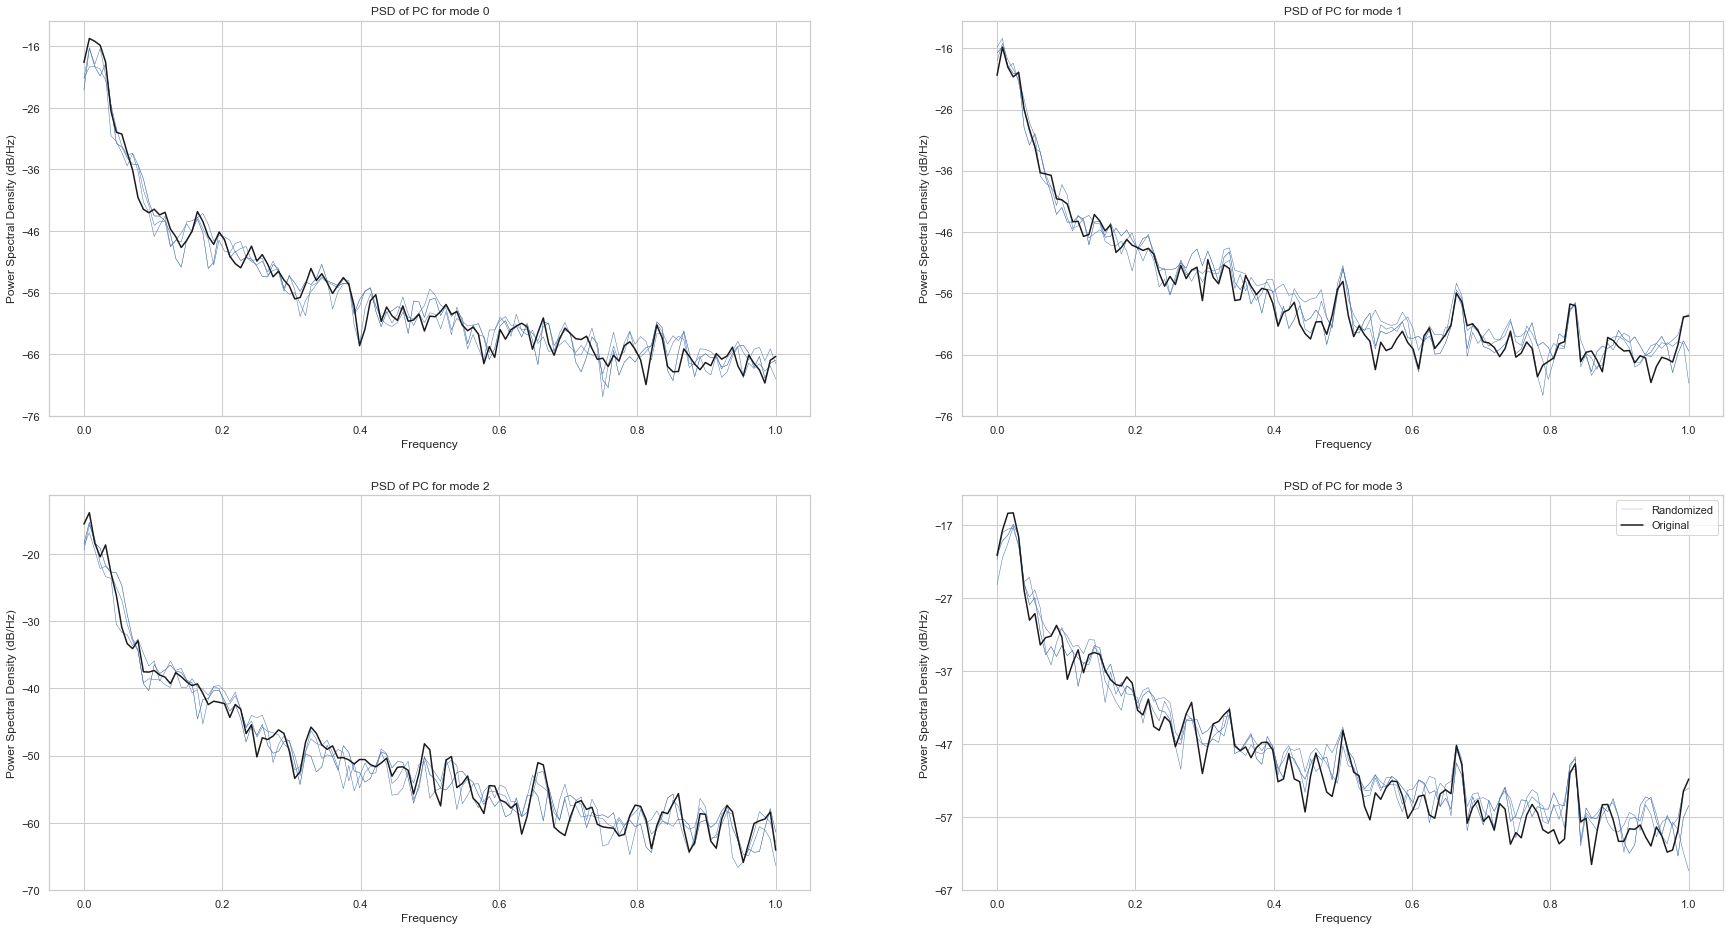

In [80]:
# FIGURE (FOR TESTING)

fig, axs = plt.subplots(2,2,figsize=(30,16))
axs=axs.ravel()

for mode_m in range(0,4):
    for i in range(0,3):
        axs[mode_m].psd(new_fl[i,:,mode_m],color='b', linewidth=0.5)
    axs[mode_m].psd(new_fl[0,:,mode_m],color='b', linewidth=0.25,label='Randomized')
    axs[mode_m].psd(stdpcs[:,mode_m],color='k', linewidth=1.5,label='Original')
    axs[mode_m].set_title('PSD of PC for mode {}'.format(mode_m))
plt.legend()

## Helper Functions

In [81]:
#modified to not return f - in calculation of RMSE, only Px required
def psd_calc_grid(data,y,x):
    f, Px = scipy.signal.welch(data[:,y,x])
    return Px

In [82]:
def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

In [95]:
# Reconstruct flux dataset using phase randomized PCs
# This section is to be called iteratively for ensemble runs with multiple realizations
# This method also takes 'modes' as a parameter: 
# which is used to reconstruct dataset with different number of selected modes

def generate_data(n_realization,mode,mode_skip):
    flux_reconstr = stdmodel.reconstruct_randomized_X(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr

In [84]:
def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping))
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    clipped_data = clipped_data.drop("month")
    return clipped_data

## Generator

In [97]:
# Generate dataset realizations
# Note standardized input data to the initial PCA 
for i in range(n_realizations):
    flux_reconstr = generate_data(i, 1, 1)
    flux_reconstr = (flux_reconstr*flux_clean_tstd)+flux_clean_tmean
    flux_reconstr.to_netcdf(inDirName+interim_data_folder+
                            cise_file_path+std_file_path+"flux_reconstr_std_{}.nc".format(i))
    del flux_reconstr
    gc.collect()
    print('reconstructed realization # {}'.format(i))

reconstructed realization # 0
reconstructed realization # 1
reconstructed realization # 2


In [98]:
# change file name for other realizations
flux_reconstr0 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+'flux_reconstr_std_0.nc')
flux_reconstr0 = flux_reconstr0.reconstructed_data

flux_reconstr1 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+'flux_reconstr_std_1.nc')
flux_reconstr1 = flux_reconstr1.reconstructed_data

flux_reconstr2 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+'flux_reconstr_std_2.nc')
flux_reconstr2 = flux_reconstr2.reconstructed_data

In [85]:
basins = np.array((34,55,114,103,104,105))

In [99]:
for basin in basins:
    orig = clip_data(flux_clean, basin)
    rec0 = clip_data(flux_reconstr0, basin)
    rec1 = clip_data(flux_reconstr1, basin)
    rec2 = clip_data(flux_reconstr2, basin)
    orig.to_netcdf(inDirName+interim_data_folder+clise_file_path+std_file_path+"orig_{}".format(basin))
    rec0.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_{}".format(basin))
    rec1.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_{}".format(basin))
    rec2.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_{}".format(basin))
    del orig, rec0, rec1, rec2
    gc.collect()

In [100]:
# Amery 34
orig_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_34")
rec0_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_34")
rec1_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_34")
rec2_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_34")

# Filchner 55
orig_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_55")
rec0_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_55")
rec1_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_55")
rec2_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_55")

# Thwaites 114
orig_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_114")
rec0_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_114")
rec1_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_114")
rec2_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_114")

# Ronne 103
orig_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_103")
rec0_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_103")
rec1_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_103")
rec2_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_103")

# Western Ross 104
orig_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_104")
rec0_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_104")
rec1_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_104")
rec2_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_104")

# Eastern Ross 105
orig_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_105")
rec0_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_105")
rec1_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_105")
rec2_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_105")

In [101]:
# Amery 
orig_34_ts = time_series(orig_34)
rec0_34_ts = time_series(rec0_34)
rec1_34_ts = time_series(rec1_34)
rec2_34_ts = time_series(rec2_34)

# Filchner 
orig_55_ts = time_series(orig_55)
rec0_55_ts = time_series(rec0_55)
rec1_55_ts = time_series(rec1_55)
rec2_55_ts = time_series(rec2_55)

# Thwaites 
orig_114_ts = time_series(orig_114)
rec0_114_ts = time_series(rec0_114)
rec1_114_ts = time_series(rec1_114)
rec2_114_ts = time_series(rec2_114)

# Ronne 
orig_103_ts = time_series(orig_103)
rec0_103_ts = time_series(rec0_103)
rec1_103_ts = time_series(rec1_103)
rec2_103_ts = time_series(rec2_103)

# Western Ross 
orig_104_ts = time_series(orig_104)
rec0_104_ts = time_series(rec0_104)
rec1_104_ts = time_series(rec1_104)
rec2_104_ts = time_series(rec2_104)

# Eastern Ross 
orig_105_ts = time_series(orig_105)
rec0_105_ts = time_series(rec0_105)
rec1_105_ts = time_series(rec1_105)
rec2_105_ts = time_series(rec2_105)

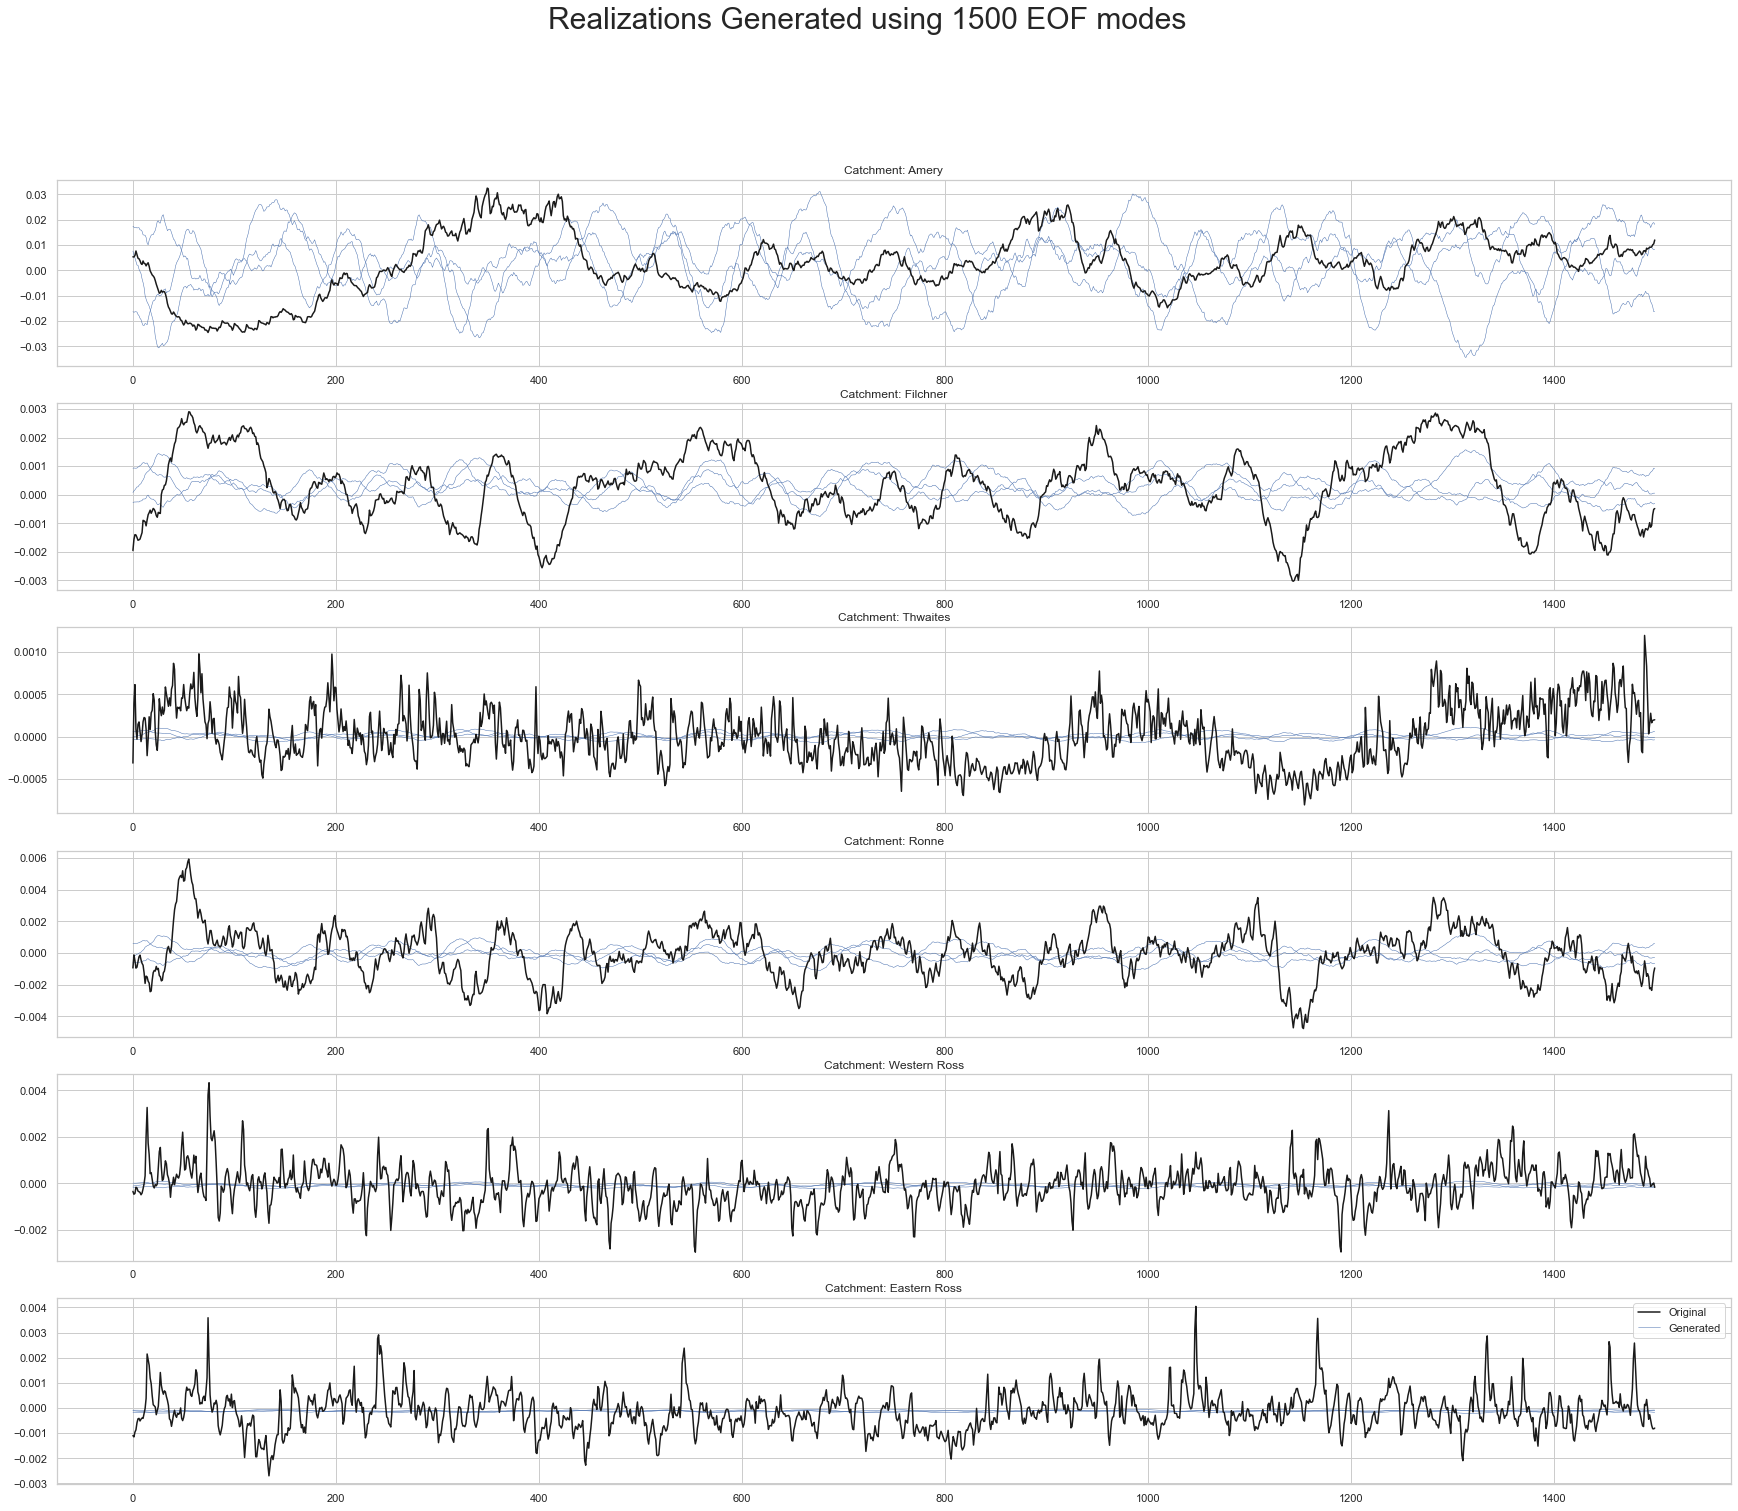

In [102]:
fig, axs = plt.subplots(6,1,figsize=(30,24))
axs=axs.ravel()

axs[0].plot(orig_34_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[0].plot(rec0_34_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[0].plot(rec1_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].plot(rec2_34_ts.reconstructed_data,color='b', linewidth=0.5);
axs[0].set_title('Catchment: Amery');

axs[1].plot(orig_55_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[1].plot(rec0_55_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[1].plot(rec1_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].plot(rec2_55_ts.reconstructed_data,color='b', linewidth=0.5);
axs[1].set_title('Catchment: Filchner');

axs[2].plot(orig_114_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[2].plot(rec0_114_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[2].plot(rec1_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].plot(rec2_114_ts.reconstructed_data,color='b', linewidth=0.5);
axs[2].set_title('Catchment: Thwaites');

axs[3].plot(orig_103_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[3].plot(rec0_103_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[3].plot(rec1_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].plot(rec2_103_ts.reconstructed_data,color='b', linewidth=0.5);
axs[3].set_title('Catchment: Ronne');

axs[4].plot(orig_104_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[4].plot(rec0_104_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[4].plot(rec1_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].plot(rec2_104_ts.reconstructed_data,color='b', linewidth=0.5);
axs[4].set_title('Catchment: Western Ross');

axs[5].plot(orig_105_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[5].plot(rec0_105_ts.reconstructed_data,color='b', linewidth=0.5,label='Generated');
axs[5].plot(rec1_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].plot(rec2_105_ts.reconstructed_data,color='b', linewidth=0.5);
axs[5].set_title('Catchment: Eastern Ross');
plt.legend()

plt.suptitle('Realizations Generated using 1500 EOF modes');